### Code to plot 90 th and 10th percentiles of vertical velocity
#### author:  Claudia Acquistapace
#### date: 09/12/2021
#### goal: plot the 90th and 10th percentiles of vertical velocity

In [1]:

# importing necessary libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.dates as mdates
import glob
import pandas as pd
import netCDF4 as nc4
string_out = '20200202_20200203'
sst_flag_file = "20200202_20200203_sst_flag10_90_perc.nc"
t_start = datetime(2020, 2, 2, 0, 0, 0)
t_end = datetime(2020, 2, 3, 23, 59, 59)
x_max_cb = 2000.
x_min_cb = 400.


In [2]:
# reading SST flag for tsg data
path_sst_flag = "/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/"
flag_file = '20200202_20200203_sst_flag10_90_perc.nc'
sst_flag = xr.open_dataset(path_sst_flag+sst_flag_file)
sst_flag

<xarray.Dataset>
Dimensions:   (time: 2880)
Coordinates:
  * time      (time) datetime64[ns] 2020-02-02T00:00:55.000003328 ... 2020-02...
Data variables:
    sst_tsg   (time) float64 ...
    flag_tsg  (time) float64 ...
Attributes:
    created_by:  Claudia Acquistapace
    created_on:  2021-12-10 12:44:38.213922
    comment:     sst flag

In [3]:

# read wind lidar data
path_wind_lidar = "/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/data_wind_lidar/"
wind_lidar_file = "wind_lidar_eurec4a.nc"
path_fig = "/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/\
SST_impact_work/plots/"
wind_lidar = xr.open_dataset(path_wind_lidar+wind_lidar_file)

# selecting time interval to extract from wind lidar dataset
wind_lidar_slice = wind_lidar.sel(time=slice(t_start, t_end))
wind_lidar_slice

<xarray.Dataset>
Dimensions:          (height: 333, time: 17280)
Coordinates:
  * height           (height) float32 15.0 45.0 75.0 ... 9915.0 9945.0 9975.0
  * time             (time) datetime64[ns] 2020-02-02 ... 2020-02-03T23:59:50
    secondsoftheday  (time) int64 ...
Data variables:
    w                (time, height) float64 ...
    cb               (time) float64 ...

In [4]:
# removing rainy time stamps from wind lidar time serie
# reading data containing flags to filter out rainy columns
flag_file_list = np.sort(glob.glob('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/*_flags_cloud_properties.nc'))
flag_file_list = flag_file_list[13:15]
flag_file_list


# filtering rainy columns from the data
flag_data = xr.open_mfdataset(flag_file_list)
flag_data_interp = flag_data.interp(time=wind_lidar_slice['time'].values, method='nearest')

# building a mask to filter out Ze rainy columns and substitute them with nans
# set to nan the values out of the thresholds for the selected variable
mask = np.zeros(len(flag_data_interp.time.values))
mask[np.where((flag_data_interp["flag_rain_ground"].values == 1) | (flag_data_interp["flag_rain"].values == 1))[0]] = 1 

time = wind_lidar_slice.time.values
wind_lidar_no_rain = wind_lidar_slice.sel(time=time[mask == 0])

# interpolating sst data at 1 s resolution to the 10 s res of the wind lidar
sst_data_interp = sst_flag.interp(time=wind_lidar_no_rain['time'].values)

# merging the interpolated dataset and the wind lidar dataset
data_merged = xr.merge([wind_lidar_no_rain, sst_data_interp])

# looking at the subcloud layer
data_subcloud = data_merged.sel(height=slice(200., 700.))


# find indeces of cold and warm values
i_cold = np.where(data_subcloud['flag_tsg'].values == 1)[0]
i_warm = np.where(data_subcloud['flag_tsg'].values == 2)[0]

# selecting corresponding datasets
time = data_subcloud.time.values
data_cold = data_subcloud.sel(time=time[i_cold])
data_warm = data_subcloud.sel(time=time[i_warm])

w_cold = data_cold.w.values.flatten()
w_warm = data_warm.w.values.flatten()

N_tot_w_cold = len(w_cold)
N_tot_w_warm = len(w_warm)
print(N_tot_w_cold, N_tot_w_warm)

# calculate mean and standard deviation of the distributions
print('mean of w warm ', np.nanmean(w_warm), 'median of w warm ',  np.nanmedian(w_warm))
print('mean of w cold ', np.nanmean(w_cold), 'median of w cold ',  np.nanmedian(w_cold))
print('std of w warm ', np.nanstd(w_warm))
print('std of w cold ', np.nanstd(w_cold))

26400 23024
mean of w warm  -0.02839314166459652 median of w warm  -0.11890000104904175
mean of w cold  0.04874561326997694 median of w cold  0.026749998331069943
std of w warm  0.5040541860879566
std of w cold  0.24325426148517434


In [5]:
sst_flag
print('len cold time stamps ', len(np.where(sst_flag['flag_tsg'].values == 1)[0]))
print('len warm time stamps ', len(np.where(sst_flag['flag_tsg'].values == 2)[0]))
print('len of the time array', len(sst_flag['flag_tsg'].values))
print('len cold time stamps interpolated ', len(np.where(sst_data_interp['flag_tsg'].values == 1)[0]))
print('len warm time stamps interpolated ', len(np.where(sst_data_interp['flag_tsg'].values == 2)[0]))


len cold time stamps  287
len warm time stamps  287
len of the time array 2880
len cold time stamps interpolated  1650
len warm time stamps interpolated  1439


In [6]:
# merging the interpolated dataset and the wind lidar dataset
data_merged = xr.merge([wind_lidar_slice, sst_data_interp])

# selecting data in the lowest 300 m and from 500 to 800 m
data_surf = data_merged.sel(height=slice(0., 300.))
data_cloud = data_merged.sel(height=slice(500., 1000.))

# calculating mean over height for both datasets
data_surf_mean = data_surf.mean(dim='height', skipna=True)
w_surf = data_surf_mean['w'].values

flag = data_surf_mean['flag_tsg'].values


# selecting cold and warm dataset indeces
i_cold = np.where(flag == 1)
i_warm = np.where(flag == 2)

# reading wind and cloud base
w_cold = w_surf[i_cold]
w_warm = w_surf[i_warm]
#cb_cold = cb_surf[i_cold]
#cb_warm = cb_surf[i_warm]


# calculating standard deviation for every 

/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  index = joiner(matching_indexes)


In [9]:
import matplotlib as mpl
# interpolating sst data at 1 s resolution to the 10 s res of the wind lidar
sst_data_interp = sst_flag.interp(time=wind_lidar_slice['time'].values)


dict_plot_settings = {
    'labelsizeaxes':32,
    'fontSizeTitle':32,
    'fontSizeX'    :32,
    'fontSizeY'    :32,
    'cbarAspect'   :32,
    'fontSizeCbar' :32,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :32, 
    'grid'         :True}


# read w binned values over SST to prepare the composite plot
path_SST_binned = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/binned_sst/'
filename = 'arthus_binned_WV_coarser_sst.nc'
arthus_data = xr.open_dataset(path_SST_binned+filename)
W_data = arthus_data['VW'].values
W_std = arthus_data['VW_std'].values
sst_arr = arthus_data['sst'].values
height = arthus_data['height'].values



In [10]:
arthus_data

<xarray.Dataset>
Dimensions:  (height: 57, sst: 28)
Coordinates:
  * sst      (sst) float64 26.28 26.33 26.38 26.43 ... 27.48 27.53 27.58 27.63
  * height   (height) float32 225.0 275.0 325.0 375.0 ... 2925.0 2975.0 3025.0
Data variables:
    VW       (sst, height) float64 0.2165 0.2288 0.2302 0.2235 ... nan nan nan
    VW_std   (sst, height) float64 0.2888 0.3105 0.3243 0.3256 ... nan nan nan
    VW_n     (sst, height) int64 ...
Attributes:
    CREATED_BY:        Claudia Acquistapace
    CREATED_ON:        2022-09-07 12:03:11.394438
    FILL_VALUE:        NaN
    PI_NAME:           Claudia Acquistapace
    PI_AFFILIATION:    University of Cologne (UNI), Germany
    PI_ADDRESS:        Institute for geophysics and meteorology, Pohligstrass...
    PI_MAIL:           cacquist@meteo.uni-koeln.de
    DATA_DESCRIPTION:  Vertical velocitywith the diurnal cycle removed from t...
    DATA_DISCIPLINE:   Atmospheric Physics - Remote Sensing Lidar Profiler
    DATA_GROUP:        Experimental;Profile;Moving
    DATA_SOURCE:       arthus data
    DATA_PROCESSING:   https://github.com/ClauClouds/SST-impact/
    INSTRUMENT_MODEL:  arthus raman lidar system
    COMMENT:           original data postprocessed by Diego Lange

In [11]:
ten_per_value = 26.4363 
ninth_per_value = 27.4587

# calculating uncertainty propagation for wind lidar w obs
from myFunctions import f_uncertainty_prop #f_uncertainty_prop(data, sigma_o, n_days, n_sigma, varstring):
''' function to propagate the uncertainty in the measurement and calculate the non-significative bins)
    inputs:
    - data: xarray dataset of data to be plotted
    - sigma_o: initial uncertainty in the data to be provided 
    - n_days: number of days used for the computation of the diurnal cycle
    - n_sigma: number of sigma chosen to check whether the measurement is different than zero.
    - varstring: string identifying the variable name
    outputs: 
    - result : xarray with values smaller than n_sigma*sigma_shf_final masked ''' 
masked_w = f_uncertainty_prop(arthus_data, 0.3, 8, 3, 'VW')



/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in true_divide
  result_data = func(*input_data)


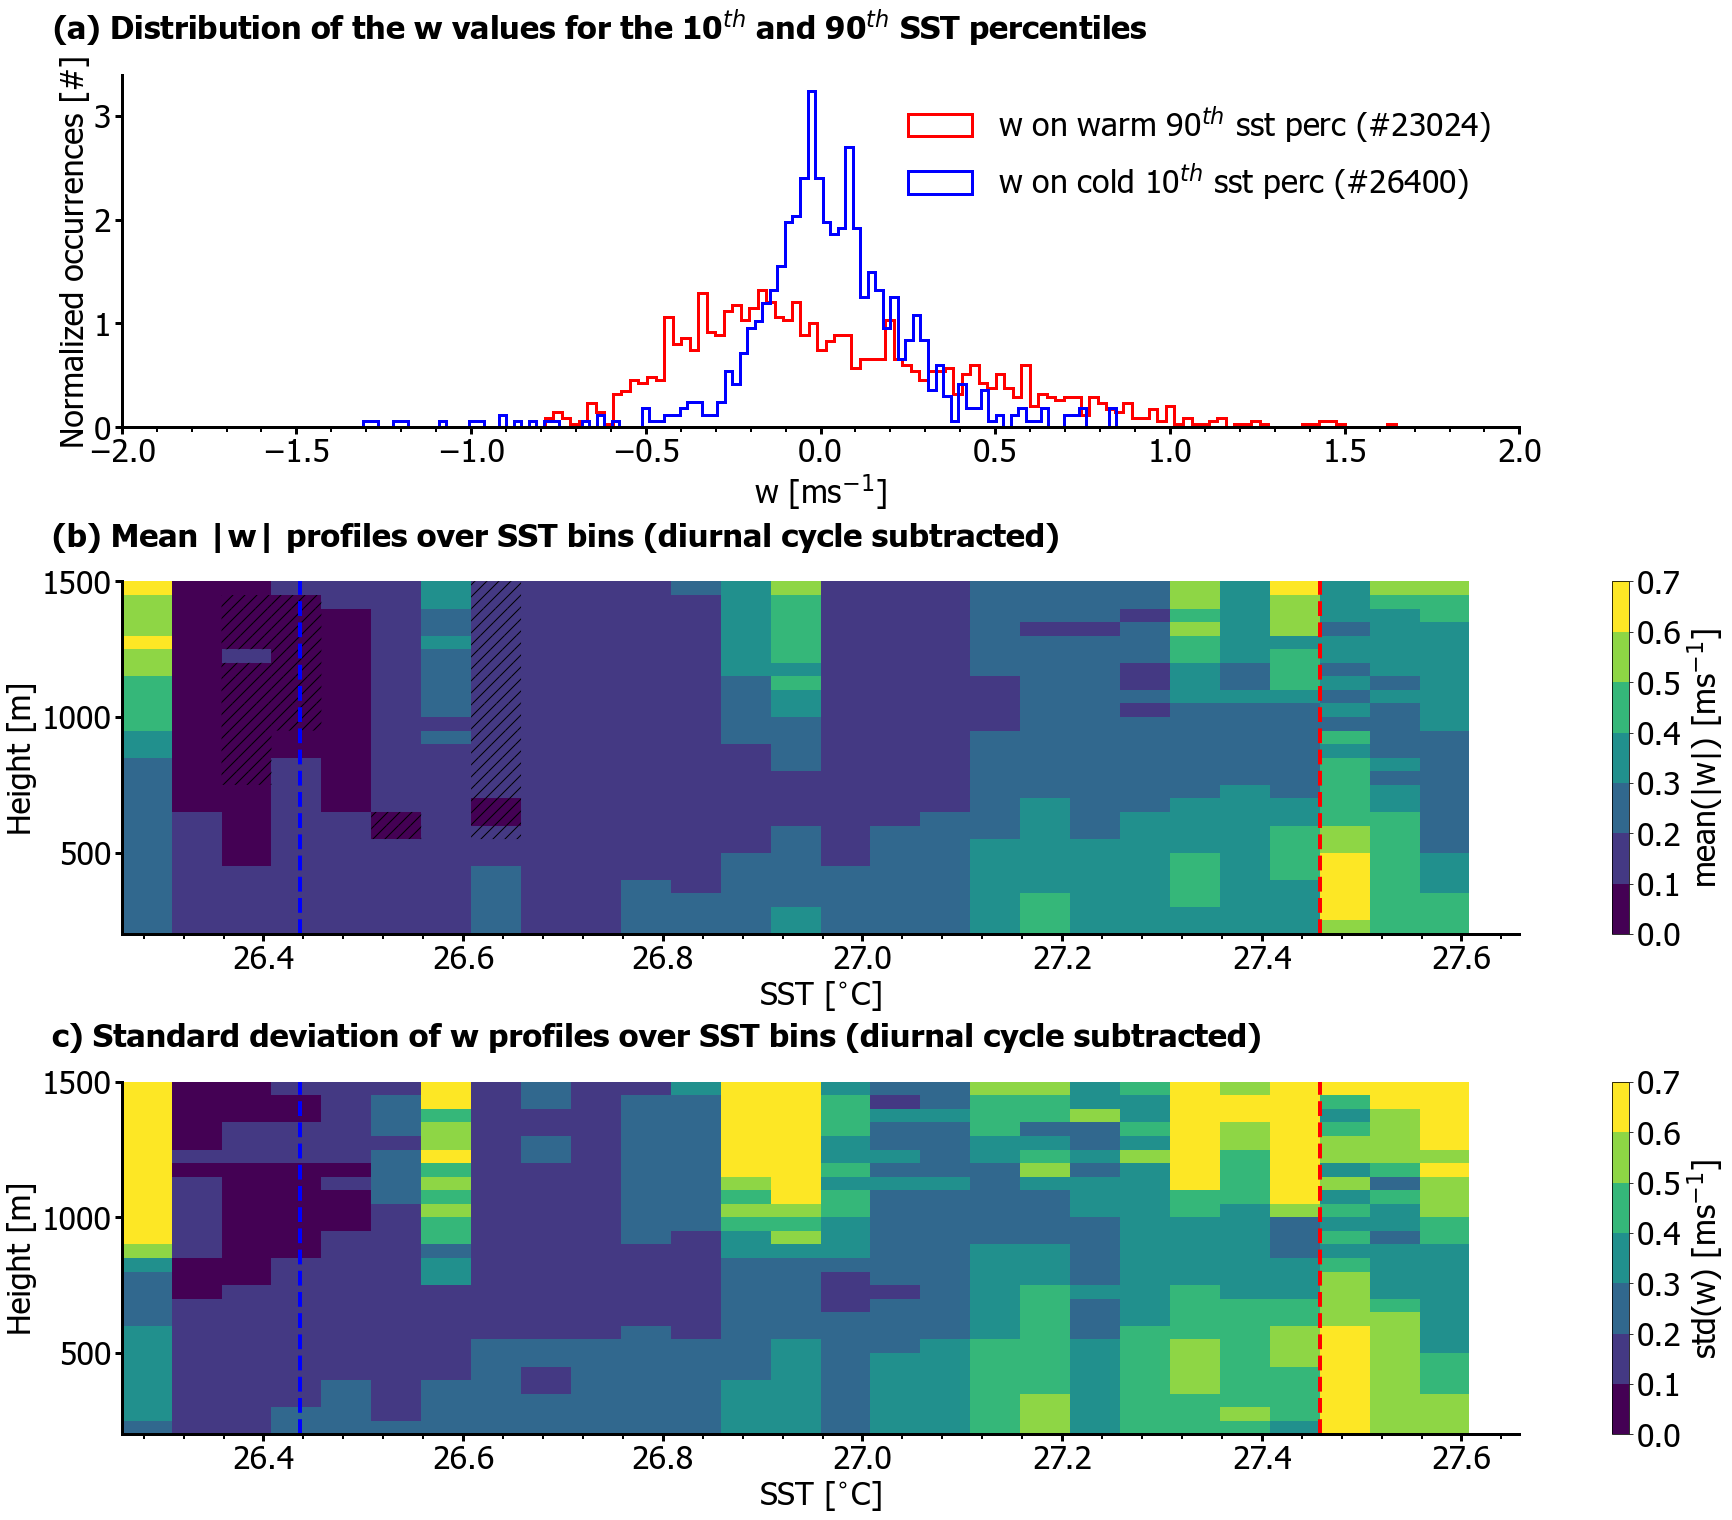

In [12]:
# composite figure variables binned in sst 
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots_paper/'

# plots settings defined by user at the top
labelsizeaxes   = dict_plot_settings['labelsizeaxes']
fontSizeTitle   = dict_plot_settings['fontSizeTitle']
fontSizeX       = dict_plot_settings['fontSizeX']
fontSizeY       = dict_plot_settings['fontSizeY']
cbarAspect      = dict_plot_settings['cbarAspect']
fontSizeCbar    = dict_plot_settings['fontSizeCbar']
rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
plt.rcParams.update({'font.size':dict_plot_settings['font_size']})
grid = dict_plot_settings['grid']

fig, axs = plt.subplots(3,1, figsize=(24,21), constrained_layout=True)

# setting dates formatter 
#[a.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) for a in axs[:].flatten()]
matplotlib.rc('xtick', labelsize=32)  # sets dimension of ticks in the plots
matplotlib.rc('ytick', labelsize=32)  # sets dimension of ticks in the plots
grid            = True

axs[0].hist(w_warm, bins=100, color='red', label='w on warm 90$^{th}$ sst perc (#'+str(N_tot_w_warm)+')', histtype='step', lw=3, density=True)
axs[0].hist(w_cold, bins=100, color='blue', label='w on cold 10$^{th}$ sst perc (#'+str(N_tot_w_cold)+')', histtype='step', lw=3, density=True)
axs[0].legend(frameon=False, fontsize=fontSizeX)
axs[0].set_xlim([-2.,2.])
axs[0].set_xlabel("w [ms$^{-1}$]", fontsize=fontSizeX)
axs[0].set_ylabel("Normalized occurrences [#]", fontsize=fontSizeY)

cmap = plt.cm.viridis  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.arange(0, 0.8, 0.1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


axs[1].set_ylim(200.,1500.)
mesh = axs[1].pcolormesh(sst_arr, height, W_data.T, cmap=cmap, norm = mpl.colors.BoundaryNorm(bounds, ncolors=cmap.N, clip=False))
axs[1].pcolor(sst_arr, height, masked_w.T, hatch='//', alpha=0.)

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[1])
cbar.set_label(label='mean(|w|) [ms$^{-1}$]',  size=fontSizeX)
axs[1].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[1].set_xlabel('SST [$^{\circ}$C]', fontsize=fontSizeX)
axs[1].axvline(x=ten_per_value, color='blue', linestyle='--', linewidth=4)
axs[1].axvline(x=ninth_per_value, color='red', linestyle='--', linewidth=4)

axs[2].set_ylim(200.,1500.)
mesh = axs[2].pcolormesh(sst_arr, height, W_std.T, cmap=cmap, norm = mpl.colors.BoundaryNorm(bounds, ncolors=cmap.N, clip=False))
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[2])
cbar.set_label(label='std(w) [ms$^{-1}$]',  size=fontSizeX)
axs[2].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[2].set_xlabel('SST [$^{\circ}$C]', fontsize=fontSizeX)
axs[2].axvline(x=ten_per_value, color='blue', linestyle='--', linewidth=4)
axs[2].axvline(x=ninth_per_value, color='red', linestyle='--', linewidth=4)


for ax, l in zip(axs[:].flatten(), ['(a) Distribution of the w values for the 10$^{th}$ and 90$^{th}$ SST percentiles ',  '(b) Mean |w| profiles over SST bins (diurnal cycle subtracted) ', 'c) Standard deviation of w profiles over SST bins (diurnal cycle subtracted)']):
    ax.text(-0.05, 1.1, l,  fontweight='black', fontsize=fontSizeX, transform=ax.transAxes)
    #ax.set_xlim(SST_binned_arr[0]-0.1, SST_binned_arr[-1]+0.1)
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(3)
    ax.spines["left"].set_linewidth(3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(which='minor', length=5, width=2)
    ax.tick_params(which='major', length=7, width=3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(axis='both', labelsize=32)


fig.savefig(path_out_plots+'figure_w_wind_R1.png', format='png')

In [10]:

# interpolating sst data at 1 s resolution to the 10 s res of the wind lidar
sst_data_interp = sst_flag.interp(time=wind_lidar_slice['time'].values)

# merging the interpolated dataset and the wind lidar dataset
data_merged = xr.merge([wind_lidar_slice, sst_data_interp])

# selecting data in the lowest 300 m and from 500 to 800 m
data_surf = data_merged.sel(height=slice(0., 300.))
data_cloud = data_merged.sel(height=slice(500., 1000.))

# calculating mean over height for both datasets
data_surf_mean = data_surf.mean(dim='height', skipna=True)
w_surf = data_surf_mean['w'].values
flag = data_surf_mean['flag_tsg'].values


# selecting cold and warm dataset indeces
i_cold = np.where(flag == 1)
i_warm = np.where(flag == 2)


In [16]:
axs[1].pcolor(sst_arr, height, masked_w.T, hatch='//', alpha=0.)


In [11]:
time_cold = data_merged['time'].values
i_cold = np.where(data_merged['flag_tsg'].values == 1)[0]
data_cold = data_merged.sel(time=time[i_cold])